In [1]:
from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering
from PIL import Image
import numpy as np
from math import exp
from sklearn.feature_extraction import image
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from numba import jit
from sklearn.cluster import SpectralClustering
import time
from sklearn import metrics

1. 用 spectral_clustering 实现谱聚类
    > 需要自己计算相似度矩阵
2. 用 SpectralClustering 实现谱聚类
    - 引入图像像素点的距离特征
    - 引入CH Score作为评价尺标

In [2]:
@jit(nopython=True)
def EuclideanDist(flatten_data):
    graph = np.empty(shape=(flatten_data.shape[0], flatten_data.shape[0]))
    for i in range(flatten_data.shape[0]):
        for j in range(flatten_data.shape[0]):
            graph[i][j] = (flatten_data[i][0]-flatten_data[j][0])**2+(flatten_data[i][1]-flatten_data[j][1])**2+(flatten_data[i][2]-flatten_data[j][2])**2
    return graph

In [3]:
def CosineDist(flatten_data):
    return flatten_data @ flatten_data.T

In [4]:
def res_show(img, labels_img):
    plt.subplot(121)
    plt.imshow(labels_img)
    plt.subplot(122)
    plt.imshow(img)

In [5]:
def res_cluster_show(img, labels_img, n_clusters):
    plt.imshow(img)
    for i in range(n_clusters):
        plt.figure()
        mask = np.zeros_like(labels_img)
        mask[labels_img==i] = 1
        plt.imshow(mask)

In [6]:
def block_show(img, labels_img, n_clusters):
    plt.imshow(img)
    for i in range(n_clusters):
        plt.figure()
        tmp = img
        tmp[np.where(labels_img!=i)] = 0
        plt.imshow(tmp)

In [7]:
def visualize(img,labels):#对结果可视化

    x1=np.arange(0,img.shape[1])
    x2=np.arange(0,img.shape[0])
    X1,X2=np.meshgrid(x1,x2)

    fig=plt.figure(figsize=(6,6))
    ax=fig.add_subplot(1,1,1)
    # ax.imshow(img,cmap=plt.cm.gray,alpha=0.8) #展示原图
    ax.imshow(img,cmap=plt.cm.gray) #展示原图
    ax.contour(X1,X2,labels,linewidths=0.5,colors='blue')#切割线
    # ax.get_xaxis().set_visible(False)#去掉坐标轴
    # ax.get_yaxis().set_visible(False)
    plt.show()

data.shape =  (64, 64, 3)


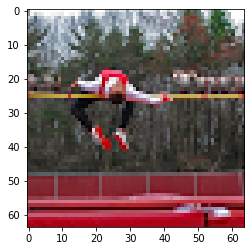

In [18]:
imgPath = "./ImageNet/00015.png"
img = Image.open(imgPath)
data = np.asarray(img)
eps = 1e-6
print("data.shape = " , data.shape)
plt.imshow(img)

Computing label assignment using discretize
Time cost =  10.425785064697266


TypeError: 'PngImageFile' object does not support item assignment

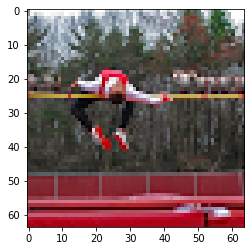

<Figure size 432x288 with 0 Axes>

In [45]:
# 余弦相似度构建
# 加 0.1 的偏置是为了避免出现除以 0，会导致 graph 不对称
flatten_data = data.reshape((-1,3)) + eps
flatten_data = flatten_data / np.linalg.norm(flatten_data, axis=1).reshape(-1, 1)
# flatten_data = flatten_data / 255
graph = CosineDist(flatten_data)
# graph = graph / np.std(graph)
graph = coo_matrix(graph) # graph.shape =  (4096, 4096)
# labels = spectral_clustering(graph, n_clusters=2, eigen_solver='arpack')
t1=time.time()
labels = spectral_clustering(graph,
                             n_clusters=3, 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True)
t2=time.time()
print('Time cost = ', t2-t1)
labels_img = labels.reshape(data.shape[0], data.shape[1])
# visualize(data, labels_img)
# res_show(img, labels_img)
# res_cluster_show(img, labels_img, 2)
block_show(img, labels_img, 3)

Computing label assignment using discretize
Time cost =  6.797931671142578


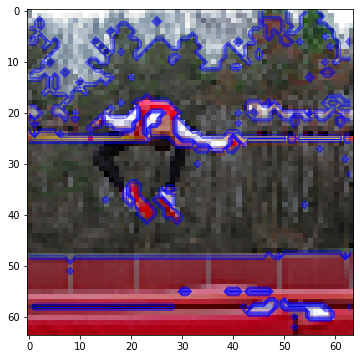

In [21]:
flatten_data = data.reshape((-1,3)).astype('int') + eps
flatten_data = flatten_data / 255
graph = EuclideanDist(flatten_data)
graph = np.exp(-graph/2)
graph = coo_matrix(graph) # graph.shape =  (4096, 4096)
# labels = spectral_clustering(graph, n_clusters=3, eigen_solver='arpack')
t1=time.time()
labels = spectral_clustering(graph,
                             n_clusters=3, 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True)
t2=time.time()
print('Time cost = ', t2-t1)
labels_img = labels.reshape(data.shape[0], data.shape[1])
# res_show(img, labels_img)
# res_cluster_show(img, labels_img, 3)
visualize(data, labels_img)

### 换用 SpectralClustering

In [21]:
help(spectral_clustering)

Help on function spectral_clustering in module sklearn.cluster._spectral:

spectral_clustering(affinity, *, n_clusters=8, n_components=None, eigen_solver=None, random_state=None, n_init=10, eigen_tol=0.0, assign_labels='kmeans', verbose=False)
    Apply clustering to a projection of the normalized Laplacian.
    
    In practice Spectral Clustering is very useful when the structure of
    the individual clusters is highly non-convex or more generally when
    a measure of the center and spread of the cluster is not a suitable
    description of the complete cluster. For instance, when clusters are
    nested circles on the 2D plane.
    
    If affinity is the adjacency matrix of a graph, this method can be
    used to find normalized graph cuts.
    
    Read more in the :ref:`User Guide <spectral_clustering>`.
    
    Parameters
    ----------
    affinity : {array-like, sparse matrix} of shape (n_samples, n_samples)
        The affinity matrix describing the relationship of the sam

In [24]:
help(SpectralClustering)

Help on class SpectralClustering in module sklearn.cluster._spectral:

class SpectralClustering(sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  Apply clustering to a projection of the normalized Laplacian.
 |  
 |  In practice Spectral Clustering is very useful when the structure of
 |  the individual clusters is highly non-convex, or more generally when
 |  a measure of the center and spread of the cluster is not a suitable
 |  description of the complete cluster, such as when clusters are
 |  nested circles on the 2D plane.
 |  
 |  If the affinity matrix is the adjacency matrix of a graph, this method
 |  can be used to find normalized graph cuts.
 |  
 |  When calling ``fit``, an affinity matrix is constructed using either
 |  a kernel function such the Gaussian (aka RBF) kernel with Euclidean
 |  distance ``d(X, X)``::
 |  
 |          np.exp(-gamma * d(X,X) ** 2)
 |  
 |  or a k-nearest neighbors connectivity matrix.
 |  
 |  Alternatively, a user-provided affinity mat

Computing label assignment using discretize
Time cost =  2.6006827354431152


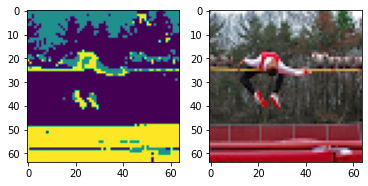

In [23]:
# 采用高斯核函数
n_clusters=3
gamma = 0.9
flatten_data = data.reshape((-1,3)).astype('int') + eps
flatten_data = flatten_data / 255
t1=time.time()
cluster = SpectralClustering(n_clusters=n_clusters, 
                             gamma=gamma, 
                             affinity='rbf', 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True).fit(flatten_data)
t2=time.time()
print('Time cost = ', t2-t1)
labels_img = cluster.labels_.reshape(data.shape[0], data.shape[1])
res_show(img, labels_img)

D:\Anaconda3\envs\python36\lib\site-packages\sklearn\neighbors\_base.py:176: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


Computing label assignment using discretize
Time cost =  3.161748170852661


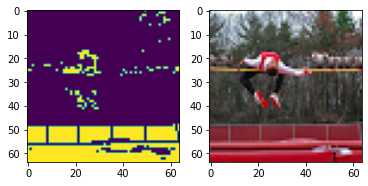

In [12]:
# 余弦相似度构建
n_clusters=2
n_neighbors=20
# 加 0.1 的偏置是为了避免出现除以 0，会导致 graph 不对称
flatten_data = data.reshape((-1,3)) + eps
flatten_data = flatten_data / np.linalg.norm(flatten_data, axis=1).reshape(-1, 1)
# flatten_data = flatten_data / 255
graph = CosineDist(flatten_data)
# graph = graph / np.std(graph)
graph = coo_matrix(graph) # graph.shape =  (4096, 4096)
# labels = spectral_clustering(graph, n_clusters=2, eigen_solver='arpack')
t1=time.time()
cluster = SpectralClustering(n_clusters=n_clusters, 
                             affinity='precomputed_nearest_neighbors', 
                             n_neighbors=n_neighbors, 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True).fit(graph)
t2=time.time()
print('Time cost = ', t2-t1)
labels_img = cluster.labels_.reshape(data.shape[0], data.shape[1])
res_show(img, labels_img)

Computing label assignment using discretize
Time cost =  0.14318370819091797


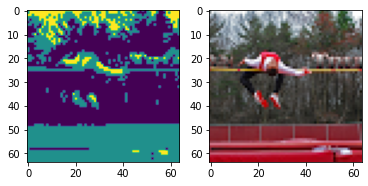

In [24]:
# 采用 k 近邻——速度很快！
n_clusters=3
flatten_data = data.reshape((-1,3)).astype('int') + eps
flatten_data = flatten_data / 255
t1=time.time()
cluster = SpectralClustering(n_clusters=n_clusters, 
                             affinity='nearest_neighbors', 
                             n_neighbors=10, 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True).fit(flatten_data)
t2=time.time()
print('Time cost = ', t2-t1)
labels_img = cluster.labels_.reshape(data.shape[0], data.shape[1])
res_show(img, labels_img)

### 尝试引入图像位置特征

In [153]:
ap = np.indices((data.shape[0], data.shape[1])).transpose(1, 2, 0)

In [154]:
ap

array([[[ 0,  0],
        [ 0,  1],
        [ 0,  2],
        ...,
        [ 0, 61],
        [ 0, 62],
        [ 0, 63]],

       [[ 1,  0],
        [ 1,  1],
        [ 1,  2],
        ...,
        [ 1, 61],
        [ 1, 62],
        [ 1, 63]],

       [[ 2,  0],
        [ 2,  1],
        [ 2,  2],
        ...,
        [ 2, 61],
        [ 2, 62],
        [ 2, 63]],

       ...,

       [[61,  0],
        [61,  1],
        [61,  2],
        ...,
        [61, 61],
        [61, 62],
        [61, 63]],

       [[62,  0],
        [62,  1],
        [62,  2],
        ...,
        [62, 61],
        [62, 62],
        [62, 63]],

       [[63,  0],
        [63,  1],
        [63,  2],
        ...,
        [63, 61],
        [63, 62],
        [63, 63]]])

In [157]:
data = np.append(data, ap, axis=2)

In [158]:
data

array([[[119, 139, 146,   0,   0],
        [255, 255, 255,   0,   1],
        [255, 255, 255,   0,   2],
        ...,
        [255, 255, 255,   0,  61],
        [255, 255, 255,   0,  62],
        [255, 255, 255,   0,  63]],

       [[139, 144, 145,   1,   0],
        [242, 244, 245,   1,   1],
        [185, 199, 208,   1,   2],
        ...,
        [255, 255, 255,   1,  61],
        [255, 255, 255,   1,  62],
        [255, 255, 255,   1,  63]],

       [[201, 208, 216,   2,   0],
        [166, 180, 193,   2,   1],
        [ 80,  95, 102,   2,   2],
        ...,
        [254, 254, 254,   2,  61],
        [254, 255, 254,   2,  62],
        [255, 255, 254,   2,  63]],

       ...,

       [[184,  28,  53,  61,   0],
        [182,  18,  49,  61,   1],
        [181,  18,  45,  61,   2],
        ...,
        [164,   8,  27,  61,  61],
        [157,   4,  20,  61,  62],
        [161,   7,  24,  61,  63]],

       [[171,   0,  20,  62,   0],
        [177,   8,  30,  62,   1],
        [170,   0

In [31]:
# ap = np.indices((data.shape[0], data.shape[1])).transpose(1, 2, 0) / max(data.shape[0], data.shape[1])
ap = (np.indices((data.shape[0], data.shape[1])).transpose(1, 2, 0) + (255 - max(data.shape[0], data.shape[1]))) / 255
ap

array([[[0.74901961, 0.74901961],
        [0.74901961, 0.75294118],
        [0.74901961, 0.75686275],
        ...,
        [0.74901961, 0.98823529],
        [0.74901961, 0.99215686],
        [0.74901961, 0.99607843]],

       [[0.75294118, 0.74901961],
        [0.75294118, 0.75294118],
        [0.75294118, 0.75686275],
        ...,
        [0.75294118, 0.98823529],
        [0.75294118, 0.99215686],
        [0.75294118, 0.99607843]],

       [[0.75686275, 0.74901961],
        [0.75686275, 0.75294118],
        [0.75686275, 0.75686275],
        ...,
        [0.75686275, 0.98823529],
        [0.75686275, 0.99215686],
        [0.75686275, 0.99607843]],

       ...,

       [[0.98823529, 0.74901961],
        [0.98823529, 0.75294118],
        [0.98823529, 0.75686275],
        ...,
        [0.98823529, 0.98823529],
        [0.98823529, 0.99215686],
        [0.98823529, 0.99607843]],

       [[0.99215686, 0.74901961],
        [0.99215686, 0.75294118],
        [0.99215686, 0.75686275],
        .

In [32]:
data = np.asarray(img)
data = (data + eps)/255
ap = (np.indices((data.shape[0], data.shape[1])).transpose(1, 2, 0) + (255 - max(data.shape[0], data.shape[1]))) / 255
data = np.append(data, ap, axis=2)
data.shape

(64, 64, 5)

Computing label assignment using discretize
Time cost =  0.29663658142089844


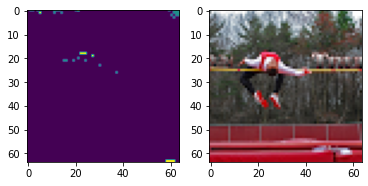

In [33]:
# 采用 k 近邻，并加入位置信息
n_clusters=3
n_neighbors=10
flatten_data = data.reshape((-1, 5)).astype('int') + eps
t1=time.time()
cluster = SpectralClustering(n_clusters=n_clusters, 
                             gamma=1.0, 
                             affinity='nearest_neighbors', 
                             n_neighbors=n_neighbors, 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True).fit(flatten_data)
t2=time.time()
print('Time cost = ', t2-t1)
labels_img = cluster.labels_.reshape(data.shape[0], data.shape[1])
res_show(img, labels_img)

Computing label assignment using discretize
Time cost =  2.861639976501465


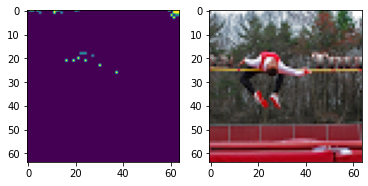

In [215]:
# 采用高斯核函数
n_clusters=3
gamma = 0.9
flatten_data = data.reshape((-1, 5)).astype('int') + eps
t1=time.time()
cluster = SpectralClustering(n_clusters=n_clusters, 
                             gamma=gamma, 
                             affinity='rbf', 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True).fit(flatten_data)
t2=time.time()
print('Time cost = ', t2-t1)
labels_img = cluster.labels_.reshape(data.shape[0], data.shape[1])
plt.subplot(121)
plt.imshow(labels_img)
plt.subplot(122)
plt.imshow(img)

### 引入 calinski_harabasz_score 度量聚类效果用以调节参数

In [226]:
img = Image.open(imgPath)
data = np.asarray(img)
eps = 1e-6

In [72]:
print('Calinski-Harabasz Score =', metrics.calinski_harabasz_score(flatten_data, cluster.labels_))

Calinski-Harabasz Score = 4490.774958533749


In [178]:
# 高斯核函数——调gamma
n_clusters=3
gamma=1.0
flatten_data = data.reshape((-1,3)).astype('int') + eps
flatten_data = flatten_data / 255
for i in range(10):
#     t1=time.time()
    cluster = SpectralClustering(n_clusters=n_clusters, 
                                 gamma=gamma, 
                                 affinity='rbf', 
                                 eigen_solver='amg', 
                                 assign_labels='discretize').fit(flatten_data)
#     t2=time.time()
#     print('Time cost = ', t2-t1)
    print('Calinski-Harabasz Score =', metrics.calinski_harabasz_score(flatten_data, cluster.labels_), '\tgamma = ', gamma)
    gamma = gamma - 0.1

Calinski-Harabasz Score = 5169.51661538117 	gamma =  1.0
Calinski-Harabasz Score = 5176.937119959712 	gamma =  0.9
Calinski-Harabasz Score = 5145.324603844986 	gamma =  0.8
Calinski-Harabasz Score = 5128.052597534099 	gamma =  0.7000000000000001
Calinski-Harabasz Score = 5108.960858373992 	gamma =  0.6000000000000001
Calinski-Harabasz Score = 5109.488086006852 	gamma =  0.5000000000000001
Calinski-Harabasz Score = 5089.680052608336 	gamma =  0.40000000000000013
Calinski-Harabasz Score = 5037.944925872671 	gamma =  0.30000000000000016
Calinski-Harabasz Score = 4989.574182958647 	gamma =  0.20000000000000015
Calinski-Harabasz Score = 4946.0160629014 	gamma =  0.10000000000000014


In [179]:
# 高斯核函数——调聚类数
n_clusters=2
gamma=0.9
flatten_data = data.reshape((-1,3)).astype('int') + eps
flatten_data = flatten_data / 255
for i in range(4):
#     t1=time.time()
    cluster = SpectralClustering(n_clusters=n_clusters, 
                                 gamma=gamma, 
                                 affinity='rbf', 
                                 eigen_solver='amg', 
                                 assign_labels='discretize').fit(flatten_data)
#     t2=time.time()
#     print('Time cost = ', t2-t1)
    print('Calinski-Harabasz Score =', metrics.calinski_harabasz_score(flatten_data, cluster.labels_), '\tn_clusters = ', n_clusters)
    n_clusters = n_clusters + 1

Calinski-Harabasz Score = 5816.61221469961 	n_clusters =  2
Calinski-Harabasz Score = 5176.937119959712 	n_clusters =  3
Calinski-Harabasz Score = 4897.126975545858 	n_clusters =  4
Calinski-Harabasz Score = 4659.509254416456 	n_clusters =  5


Computing label assignment using discretize
Time cost =  2.515317916870117
Calinski-Harabasz Score = 5816.61221469961 	n_clusters =  2


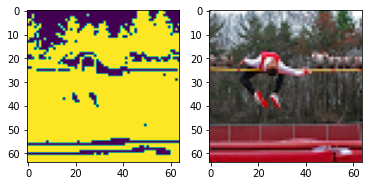

In [5]:
# 高斯核函数——结果
n_clusters=2
gamma=0.9
flatten_data = data.reshape((-1,3)).astype('int') + eps
flatten_data = flatten_data / 255
t1=time.time()
cluster = SpectralClustering(n_clusters=n_clusters, 
                             gamma=gamma, 
                             affinity='rbf', 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True).fit(flatten_data)
t2=time.time()
print('Time cost = ', t2-t1)
labels_img = cluster.labels_.reshape(data.shape[0], data.shape[1])
print('Calinski-Harabasz Score =', metrics.calinski_harabasz_score(flatten_data, cluster.labels_), '\tn_clusters = ', n_clusters)
plt.subplot(121)
plt.imshow(labels_img)
plt.subplot(122)
plt.imshow(img)

In [93]:
# k 近邻——调 k
n_clusters = 3
n_neighbors = 10
flatten_data = data.reshape((-1,3)).astype('int') + eps
flatten_data = flatten_data / 255
for i in range(10):
    n_neighbors = n_neighbors + i * 2
#     t1=time.time()
    cluster = SpectralClustering(n_clusters=n_clusters, 
                                 affinity='nearest_neighbors', 
                                 n_neighbors=n_neighbors, 
                                 eigen_solver='amg', 
                                 assign_labels='discretize').fit(flatten_data)
#     t2=time.time()
#     print('Time cost = ', t2-t1)
    print('Calinski-Harabasz Score =', metrics.calinski_harabasz_score(flatten_data, cluster.labels_), '\tn_neighbors = ', n_neighbors)

Calinski-Harabasz Score = 3697.9917726102726 	n_neighbors =  10
Calinski-Harabasz Score = 3819.7701999642304 	n_neighbors =  12
Calinski-Harabasz Score = 4068.7837326941617 	n_neighbors =  16
Calinski-Harabasz Score = 4397.585806492221 	n_neighbors =  22
Calinski-Harabasz Score = 4828.144313957051 	n_neighbors =  30
Calinski-Harabasz Score = 4940.833325614771 	n_neighbors =  40
Calinski-Harabasz Score = 4989.570052354542 	n_neighbors =  52
Calinski-Harabasz Score = 4996.825456907886 	n_neighbors =  66
Calinski-Harabasz Score = 4943.4635428088395 	n_neighbors =  82
Calinski-Harabasz Score = 4865.608285188805 	n_neighbors =  100


In [191]:
# k 近邻——微调 k
n_clusters = 3
n_neighbors = 52
flatten_data = data.reshape((-1,3)).astype('int') + eps
flatten_data = flatten_data / 255
for i in range(20):
    n_neighbors = n_neighbors + 1
#     t1=time.time()
    cluster = SpectralClustering(n_clusters=n_clusters, 
                                 affinity='nearest_neighbors', 
                                 n_neighbors=n_neighbors, 
                                 eigen_solver='amg', 
                                 assign_labels='discretize').fit(flatten_data)
#     t2=time.time()
#     print('Time cost = ', t2-t1)
    print('Calinski-Harabasz Score =', metrics.calinski_harabasz_score(flatten_data, cluster.labels_), '\tn_neighbors = ', n_neighbors)

Calinski-Harabasz Score = 4980.547687025913 	n_neighbors =  53
Calinski-Harabasz Score = 4984.584261229431 	n_neighbors =  54
Calinski-Harabasz Score = 4990.456529152382 	n_neighbors =  55
Calinski-Harabasz Score = 4991.996104491346 	n_neighbors =  56
Calinski-Harabasz Score = 4992.423216571519 	n_neighbors =  57
Calinski-Harabasz Score = 5003.2848321047795 	n_neighbors =  58
Calinski-Harabasz Score = 5005.584562711012 	n_neighbors =  59
Calinski-Harabasz Score = 5007.957740385782 	n_neighbors =  60
Calinski-Harabasz Score = 5002.96227726628 	n_neighbors =  61
Calinski-Harabasz Score = 5002.513359032342 	n_neighbors =  62
Calinski-Harabasz Score = 5002.9687540975765 	n_neighbors =  63
Calinski-Harabasz Score = 5001.531155977752 	n_neighbors =  64
Calinski-Harabasz Score = 5001.670029912235 	n_neighbors =  65
Calinski-Harabasz Score = 4996.825456907887 	n_neighbors =  66
Calinski-Harabasz Score = 4978.468923519604 	n_neighbors =  67
Calinski-Harabasz Score = 4973.121046880458 	n_neighbo

In [229]:
# k 近邻——调整聚类数
n_clusters = 2
n_neighbors = 65
flatten_data = data.reshape((-1,3)).astype('int') + eps
flatten_data = flatten_data / 255
for i in range(10):
#     t1=time.time()
    cluster = SpectralClustering(n_clusters=n_clusters, 
                                 affinity='nearest_neighbors', 
                                 n_neighbors=n_neighbors, 
                                 eigen_solver='amg', 
                                 assign_labels='discretize').fit(flatten_data)
#     t2=time.time()
#     print('Time cost = ', t2-t1)
    print('Calinski-Harabasz Score =', metrics.calinski_harabasz_score(flatten_data, cluster.labels_), '\tn_clusters = ', n_clusters)
    n_clusters = n_clusters + 1

Calinski-Harabasz Score = 2578.738469389901 	n_clusters =  2
Calinski-Harabasz Score = 5001.670029912235 	n_clusters =  3
Calinski-Harabasz Score = 5030.717966594192 	n_clusters =  4
Calinski-Harabasz Score = 5189.114045529631 	n_clusters =  5
Calinski-Harabasz Score = 4497.360488571413 	n_clusters =  6
Calinski-Harabasz Score = 5125.520060935443 	n_clusters =  7
Calinski-Harabasz Score = 4997.105082337022 	n_clusters =  8
Calinski-Harabasz Score = 5662.629985430866 	n_clusters =  9
Calinski-Harabasz Score = 5604.066735376274 	n_clusters =  10
Calinski-Harabasz Score = 5706.130336881782 	n_clusters =  11


聚类数太大没有参考价值

Computing label assignment using discretize
Time cost =  0.46823763847351074


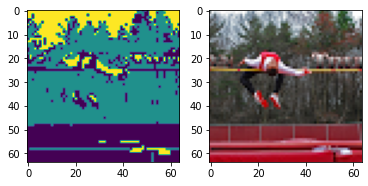

In [199]:
# 采用 k 近邻——结果
n_clusters=3
n_neighbors = 65
flatten_data = data.reshape((-1,3)).astype('int') + eps
flatten_data = flatten_data / 255
t1=time.time()
cluster = SpectralClustering(n_clusters=n_clusters, 
                             affinity='nearest_neighbors', 
                             n_neighbors=n_neighbors, 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True).fit(flatten_data)
t2=time.time()
print('Time cost = ', t2-t1)
labels_img = cluster.labels_.reshape(data.shape[0], data.shape[1])
plt.subplot(121)
plt.imshow(labels_img)
plt.subplot(122)
plt.imshow(img)

Computing label assignment using discretize
Time cost =  8.277037143707275
Calinski-Harabasz Score = 5816.61221469961


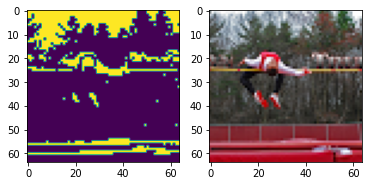

In [188]:
# 自己建立的高斯核函数
n_clusters = 2
gamma = 0.9
flatten_data = data.reshape((-1,3)).astype('int') + eps
flatten_data = flatten_data / 255
graph = EuclideanDist(flatten_data)
graph = np.exp(-graph/(2*gamma))
graph = coo_matrix(graph) # graph.shape =  (4096, 4096)
# labels = spectral_clustering(graph, n_clusters=3, eigen_solver='arpack')
t1=time.time()
labels = spectral_clustering(graph,
                             n_clusters=n_clusters, 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True)
t2=time.time()
print('Time cost = ', t2-t1)
labels_img = labels.reshape(data.shape[0], data.shape[1])
plt.subplot(121)
plt.imshow(labels_img)
plt.subplot(122)
plt.imshow(img)
print('Calinski-Harabasz Score =', metrics.calinski_harabasz_score(flatten_data, cluster.labels_))
# plt.imshow(img)

# for i in range(n_clusters):
#     plt.figure()
#     mask = np.zeros_like(labels_img)
#     mask[labels_img==i] = 1
#     plt.imshow(mask)

### 尝试灰度图

In [230]:
gray = np.array(img.convert('L'))
gray.shape

(64, 64)

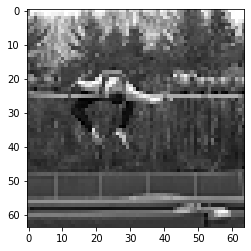

In [233]:
plt.imshow(img.convert('L'), cmap='gray')

In [234]:
gray

array([[134, 255, 255, ..., 255, 255, 255],
       [143, 244, 196, ..., 255, 255, 255],
       [207, 177,  91, ..., 254, 255, 255],
       ...,
       [ 77,  71,  70, ...,  57,  52,  55],
       [ 53,  61,  53, ...,  54,  55,  53],
       [ 50,  54,  57, ...,  56,  59,  64]], dtype=uint8)

data.shape =  (64, 64, 3)


NameError: name 'gray' is not defined

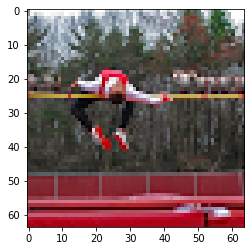

In [2]:
# 高斯核函数——结果
n_clusters=3
gamma=0.9
flatten_data = gray.reshape((-1,1)).astype('int') + eps
flatten_data = flatten_data / 255
t1=time.time()
cluster = SpectralClustering(n_clusters=n_clusters, 
                             gamma=gamma, 
                             affinity='rbf', 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True).fit(flatten_data)
t2=time.time()
print('Time cost = ', t2-t1)
print('Calinski-Harabasz Score =', metrics.calinski_harabasz_score(flatten_data, cluster.labels_), '\tn_clusters = ', n_clusters)
plt.subplot(121)
plt.imshow(labels_img)
plt.subplot(122)
plt.imshow(img)

Computing label assignment using discretize
Time cost =  2.48439621925354
Calinski-Harabasz Score = 5816.61221469961 	n_clusters =  2


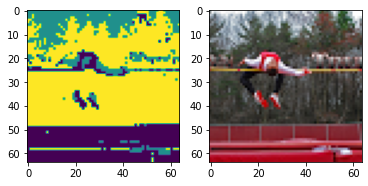

In [237]:
# 高斯核函数——结果
n_clusters=2
gamma=0.9
flatten_data = data.reshape((-1,3)).astype('int') + eps
flatten_data = flatten_data / 255
t1=time.time()
cluster = SpectralClustering(n_clusters=n_clusters, 
                             gamma=gamma, 
                             affinity='rbf', 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True).fit(flatten_data)
t2=time.time()
print('Time cost = ', t2-t1)
print('Calinski-Harabasz Score =', metrics.calinski_harabasz_score(flatten_data, cluster.labels_), '\tn_clusters = ', n_clusters)
plt.subplot(121)
plt.imshow(labels_img)
plt.subplot(122)
plt.imshow(img)

In [36]:
import cv2

In [35]:
!pip install opencv-python

Looking in indexes: http://pypi.douban.com/simple
Note: you may need to restart the kernel to use updated packages.


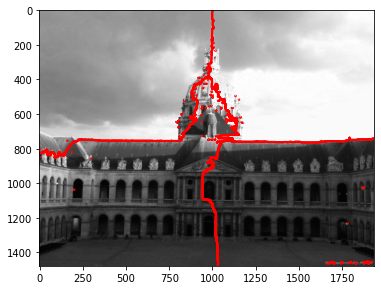

Time cost =  109.46658444404602


In [20]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering


class img_seg():

	def load_img(self,path):
		sample_img=cv2.imread(path)[:,:,2] #对于彩色图片，作为例子我们只选取1个channel 
		sample_img=sample_img/255.
		
		#用img_to_graph将img转化为graph，每个位置计算的是相邻像素点这之间的差（梯度）
		graph=image.img_to_graph(sample_img)
		
		#转化为邻接矩阵（从 distance 转化为 similarity),这里做了归一化来保证更好的效果
		gamma=20
		graph.data=np.exp(-gamma*graph.data/graph.data.std())
		return sample_img,graph

	def visualize(self,img,labels):#对结果可视化

		x1=np.arange(0,img.shape[1])
		x2=np.arange(0,img.shape[0])
		X1,X2=np.meshgrid(x1,x2)

		fig=plt.figure(figsize=(6,6))
		ax=fig.add_subplot(1,1,1)
# 		ax.imshow(img,cmap=plt.cm.gray,alpha=0.8) #展示原图
		ax.imshow(img,cmap=plt.cm.gray) #展示原图
		ax.contour(X1,X2,labels,linewidths=2,colors='red')#切割线
# 		ax.get_xaxis().set_visible(False)#去掉坐标轴
# 		ax.get_yaxis().set_visible(False)
		plt.show()

	def spectral_clustering_seg(self,path):
		img,graph=self.load_img(path)
		#运行谱聚类，这里 assign_labels也可以选择kmeans, 如果eigen_solver想使用'amg',需要先安装 pyamg包
		labels=spectral_clustering(graph,n_clusters=4,assign_labels='discretize',eigen_solver='amg')
		labels=labels.reshape(img.shape)
		self.visualize(img,labels)

t1=time.time()
_=img_seg()
_.spectral_clustering_seg('paris.jpg')
t2=time.time()
print('Time cost = ', t2-t1)

data.shape =  (321, 481)


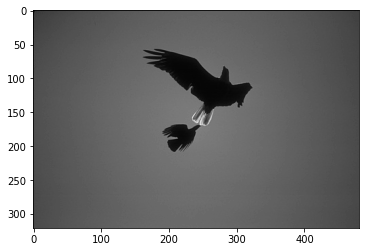

In [46]:
imgPath = "./BSDS300/images/train/135069.jpg"
img = Image.open(imgPath)
data = np.asarray(img.convert('L'))
eps = 1e-6
print("data.shape = " , data.shape)
plt.imshow(img.convert('L'), cmap='gray')

Computing label assignment using discretize
Time cost =  3.845247268676758


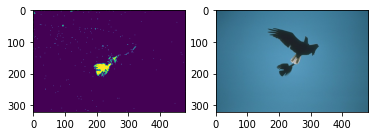

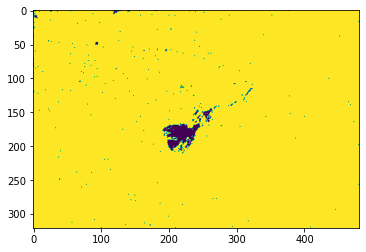

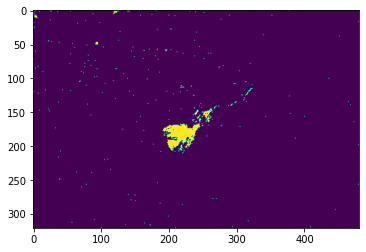

In [48]:
n_clusters=2
graph = image.img_to_graph(data)
gamma=20
graph.data=np.exp(-gamma*graph.data/graph.data.std())
t1=time.time()
labels = spectral_clustering(graph,
                             n_clusters=n_clusters, 
                             eigen_solver='amg', 
                             assign_labels='discretize', 
                             verbose=True)
t2=time.time()
print('Time cost = ', t2-t1)
labels_img = labels.reshape(data.shape[0], data.shape[1])
res_show(img, labels_img)
res_cluster_show(img, labels_img, n_clusters)